# Importing libraries and Data cleaning

In [265]:
!pip install pmdarima

In [266]:
!pip install iplot

In [267]:
 !pip install cufflinks

In [356]:
#Importing Libraries

# linear algebra
import numpy as np
import math

# data processing
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import plotly.express as py
import plotly.offline
%matplotlib inline
import seaborn as sns
import plotly.express as px
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#For lstm model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten

#for Arima model

from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller


In [269]:
df= pd.read_csv('Precipitation.csv')

df


,year,month,rainfall
0,1940,Jan,82.9
1,1940,Feb,64.9
2,1940,Mar,111.3
3,1940,Apr,56.5
4,1940,May,15.8
...,...,...,...
800,2019,Aug,3.6
801,2019,Sep,34.6
802,2019,Oct,60.4
803,2019,Nov,82.6


In [270]:
for col in df.columns:
    print(col)

year
month
rainfall


In [271]:
df.shape

(805, 3)

In [274]:
df.head()

,year,month,rainfall
0,1940,Jan,82.9
1,1940,Feb,64.9
2,1940,Mar,111.3
3,1940,Apr,56.5
4,1940,May,15.8


In [275]:
# Check how balanced our dataset is.
#sns.countplot(x="year", data=df)

In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      805 non-null    int64  
 1   month     805 non-null    object 
 2   rainfall  805 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 19.0+ KB


In [277]:
df.describe()

,year,rainfall
count,805.000000,805.00000
mean,1980.342857,68.51764
std,23.413049,66.53645
min,1940.000000,0.10000
25%,1960.000000,14.70000
50%,1981.000000,51.20000
75%,2001.000000,105.30000
max,2019.000000,416.60000


In [279]:
getmonths = df['month'].unique()
getyears = df['year'].unique()
print("Total Months: ", len(getmonths))
print("Total Years: ", len(getyears))
print("Maximum Rainfall: ", df['rainfall'].max() )
print("Minimum Rainfall: ", df['rainfall'].min() )

Total Months:  12
Total Years:  77
Maximum Rainfall:  416.6
Minimum Rainfall:  0.1


In [280]:
print("Average Rainfall of Year 2019: ",
df[df.year == 2019]["rainfall"].sum()/len(df[df.year == 2019]["rainfall"]) )


Average Rainfall of Year 2019:  53.127272727272725


# Exploratory Data Analysis

In [281]:
ax=df.groupby([df.year]).mean()['rainfall']
fig = px.line(ax, x=ax.index, y='rainfall', title='Annual rainfall in Mbombela from 1940 to 2019')
fig.update_traces(mode='lines+markers',line=dict(color='Orange'))
fig.update(layout=dict(title=dict(x=0.5)))
fig.show()

From the graph, we can see that the highest average rainfall in Mbombela was recorded in the year 1991.

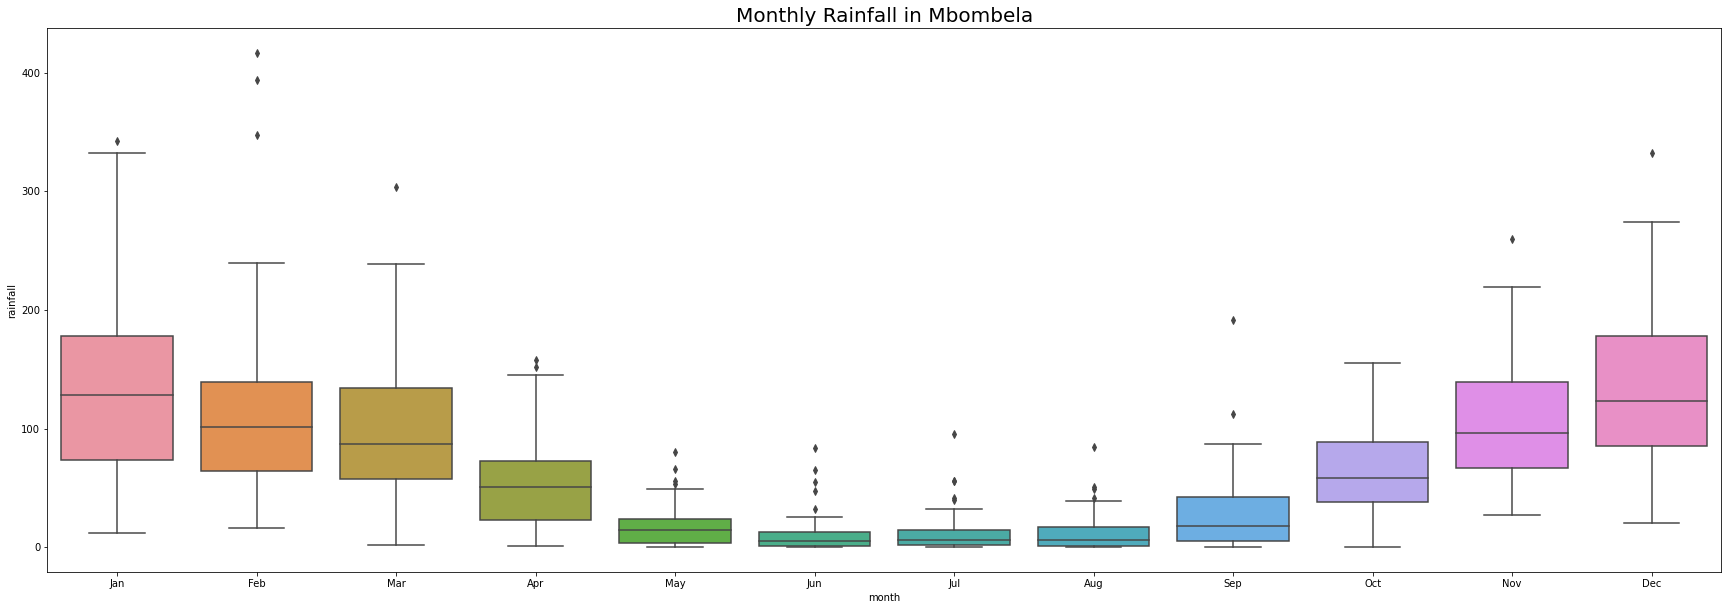

In [282]:
import warnings
warnings.filterwarnings('ignore')

f,ax=plt.subplots(1,1,figsize=(30,10))
title = plt.title('Monthly Rainfall in Mbombela', fontsize=20)
title.set_position([0.5, 1.05])

g = sns.boxplot(df["month"], df["rainfall"],ax=ax, order=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])

From the figure, the majority of the rainfall is received in the months of Dec and Jan which is the summer season while in Jun, 	July, and August the least Rainfall is recorded.


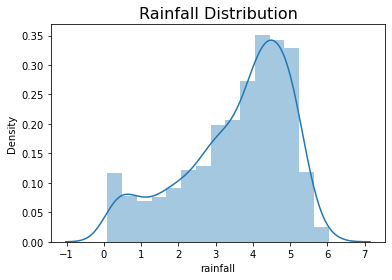

In [283]:
g1 = sns.distplot(np.log(df['rainfall'] + 1))
g1.set_title("Rainfall Distribution", fontsize=16);

# LSTM MODEL

In [284]:
#Data preprcessing
dataset = df.drop(columns = ['month','year'])
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [285]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=12):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [286]:
# split into train and test sets
training_size=int(len(dataset)*0.90)
test_size=len(dataset)-training_size
train, test =dataset[0:training_size,:],dataset[training_size:len(dataset),:1]

#reshape into X=t and Y=t+1
look_back =12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [287]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [288]:
# create and fit the LSTM network
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,look_back)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=600, batch_size=200, validation_data=(testX, testY), shuffle=False)

Epoch 1/600
4/4 [==============================] - 6s 367ms/step - loss: 0.0512 - val_loss: 0.0350
Epoch 2/600
4/4 [==============================] - 0s 6ms/step - loss: 0.0458 - val_loss: 0.0305
Epoch 3/600
4/4 [==============================] - 0s 10ms/step - loss: 0.0405 - val_loss: 0.0264
Epoch 4/600
4/4 [==============================] - 0s 5ms/step - loss: 0.0353 - val_loss: 0.0227
Epoch 5/600
4/4 [==============================] - 0s 11ms/step - loss: 0.0306 - val_loss: 0.0199
Epoch 6/600
4/4 [==============================] - 0s 9ms/step - loss: 0.0270 - val_loss: 0.0187
Epoch 7/600
4/4 [==============================] - 0s 8ms/step - loss: 0.0251 - val_loss: 0.0192
Epoch 8/600
4/4 [==============================] - 0s 11ms/step - loss: 0.0247 - val_loss: 0.0198
Epoch 9/600
4/4 [==============================] - 0s 10ms/step - loss: 0.0245 - val_loss: 0.0192
Epoch 10/600
4/4 [==============================] - 0s 10ms/step - loss: 0.0237 - val_loss: 0.0178
Epoch 11/600
4/4 [====

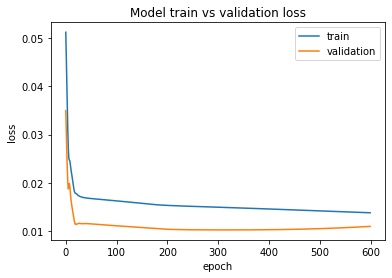

In [289]:
# plot train and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Train and Validation Learning Curves Showing a Good Fit because The plot of validation loss decreases and has a small gap with the training loss.

In [290]:
#The model is fit, now we can estimate the performance of the model on the test datasets.

In [291]:
testPredict = model.predict(testX)
# invert predictions
test_Predict = scaler.inverse_transform(testPredict)
test_Y = scaler.inverse_transform([testY])
# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(test_Y[0], test_Predict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 43.60 RMSE


In [292]:
data = df.drop(columns = ['month','year'])
testindex=data[-(testY.size):]
future_forecast = pd.DataFrame(test_Predict[:,0],index =testindex.index,columns=['Prediction'])
pd.concat([testindex,future_forecast],axis=1).iplot()

# ARIMA MODEL 

In [293]:
test_result=adfuller(df['rainfall'])
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df['rainfall'])

ADF Test Statistic : -7.200906045063223
p-value : 2.3669408812724056e-10
#Lags Used : 11
Number of Observations : 793
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


As we are working on univariate time series and Data is also stationary.So we can use Arima model.

In [294]:
# split into train and test sets


df = df.drop(columns = ['month','year'])
data_train, data_val = train_test_split(df, test_size=0.10, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  724
Validation size =  81


In [295]:
model = auto_arima(data_train, start_p=0, start_q=0,max_p=3, max_q=3, m=12,start_P=0,start_Q=0,max_P=1,max_Q=1, seasonal=True,d=0, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(data_train)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=8565.700, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=8350.648, Time=0.59 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=8563.709, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=8566.869, Time=0.06 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=8349.712, Time=0.71 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=8350.722, Time=0.45 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=8352.257, Time=1.41 sec
 ARIMA(0,0,0)(1,1,0)[12]             : AIC=8347.719, Time=0.15 sec
 ARIMA(0,0,0)(1,1,1)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(0,0,0)(0,1,1)[12]             : AIC=inf, T

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [296]:
future_forecast = model.predict(len(data_val))
future_forecast = pd.DataFrame(future_forecast,index =data_val.index,columns=['Prediction'])
pd.concat([data_val,future_forecast],axis=1).iplot()

In [297]:
testScore = math.sqrt(mean_squared_error(data_val,future_forecast))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 63.99 RMSE


# SVM MODEL

In [343]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import svm

X,y = make_classification(n_samples=77, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 0)


In [344]:
model = svm.SVR()
model.fit(X_train, y_train)
print(model)

SVR()


In [345]:
expected_y  = y_test
predicted_y = model.predict(X_test)

In [346]:
print(metrics.r2_score(expected_y, predicted_y))
print(metrics.mean_squared_error(expected_y, predicted_y))

0.47818230566551634
0.13045442358362092


<AxesSubplot:>

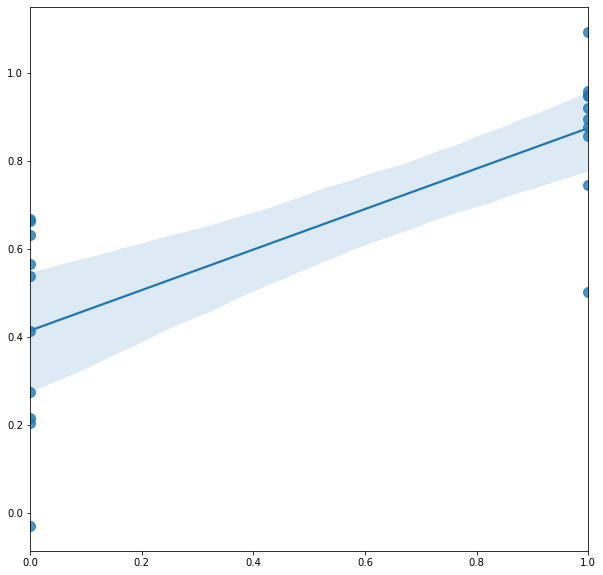

In [347]:
plt.figure(figsize=(10,10))
sns.regplot(expected_y, predicted_y, fit_reg=True, scatter_kws={"s": 100})

In [337]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
 
 
def data_pre(data):
    """
    :param data: 
    :param seq_len: 
    :return: 
    """
    row = round(0.9 * data.shape[0])
    data = data.values
    train = data[:int(row), :]
    x_train = train[:, :]
    y_train = train[:,16:17]
    x_test = data[int(row):, :]
    y_test = data[int(row):, 16:17]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]))
    return [x_train, y_train, x_test, y_test]        

   

    X_train, y_train, X_test, y_test = data_pre(df)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    
   
   

In [353]:
    clf = RandomForestRegressor(n_estimators=77, criterion='mse', max_depth=None,
                                min_samples_split=2, min_samples_leaf=1,
                                max_features='auto', max_leaf_nodes=None,
                                bootstrap=True, oob_score=False, n_jobs=1,
                                random_state=None, verbose=0)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)


In [354]:
    error = mean_squared_error(y_test, predictions)
    print('Random Forest Test MSE: %.3f' % error)


Random Forest Test MSE: 0.111


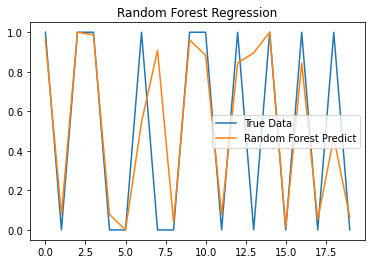

In [355]:
    plt.plot(y_test, label='True Data')
    plt.plot(predictions, label='Random Forest Predict')
    plt.title('Random Forest Regression')
    plt.legend()
    plt.show()